In [1]:
from DatasetHandler.BiwiBrowser import *
from LSTM_VGG16.LSTM_VGG16Helper import *
%matplotlib inline

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [3]:
output_begin = 4
num_outputs = 1

In [4]:
timesteps = 26 # TimeseriesGenerator Handles overlapping
in_epochs = 1
out_epochs = 1
train_batch_size = 1
test_batch_size = 1

In [5]:
subjectList = [1] #, 2, 3, 4, 5, 7, 8, 11, 12, 14 except [6, 13, 10, ]
testSubjects = [1]

In [6]:
num_datasets = len(subjectList)

In [33]:
def getImageModel(num_outputs = num_outputs):
    inp = BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = BIWI_Frame_Shape)
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2])))
    rnn.add(TimeDistributed(Flatten()))
    
    rnn.add(TimeDistributed(Dense(1024, activation='relu')))
    rnn.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, name='img_lstm', return_sequences=True))#

    for layer in rnn.layers[:15]:
        layer.trainable = False
   # rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [34]:
def getAngleModel(num_outputs = num_outputs):
    rnn = Sequential()
    #rnn.add(TimeDistributed(Input(shape=(timesteps,))))
   # rnn.add(TimeDistributed(Flatten(), input_shape=(timesteps, num_outputs)))
    #rnn.add(TimeDistributed(Reshape()))
    rnn.add(LSTM(26, dropout=0.2, recurrent_dropout=0.2, name='ang_lstm', input_shape=(timesteps, num_outputs)))
  #  rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']), return_sequences=True
    return rnn

In [35]:
def getFinalModel(num_outputs = num_outputs):
    imageModel = getImageModel(num_outputs = num_outputs)
    angleModel = getAngleModel(num_outputs = num_outputs)
    merged = merge([imageModel.output, angleModel.input], 'concat', name='matrix')#.outputC, axis=-1, mode='concat'))  keras.layers.merge
    print(merged.shape)
    #lstm = LSTM(129, dropout=0.2, recurrent_dropout=0.2, name='fnl_lstm')(lstm)
    dense = Dense(num_outputs, name='dense_finel')(merged)
    rnn = Model([imageModel.input, angleModel.input], dense)
   # rnn.add(merged)
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [36]:
keras.backend.clear_session()
full_model = getFinalModel(num_outputs = num_outputs)

(?, 26, 129)


/home/mcicek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/home/mcicek/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [37]:
full_model = trainFinalModelForEpochs(full_model, out_epochs, subjectList, testSubjects, timesteps, False, output_begin, num_outputs, batch_size = train_batch_size, in_epochs = in_epochs)

All frames and annotations from 1 datasets have been read by 2019-01-03 00:05:51.858580
1. set (Dataset 1) being trained for epoch 1!
Epoch 1/1


ValueError: Error when checking target: expected dense_finel to have 3 dimensions, but got array with shape (1, 1)

In [ ]:
#full_model.summary()

In [12]:
#[1]
test_generators, test_labelSets = getTestBiwiForFinalModel(testSubjects, timesteps, False, output_begin, num_outputs, batch_size = test_batch_size)
test_gen, test_labels = test_generators[0], test_labelSets[0] 

All frames and annotations from 1 datasets have been read by 2019-01-02 23:47:36.339417


In [13]:
def slide(m, x):
        m[0, :-1] = m[0, 1:]
        m[0, -1] = x
        return m

In [14]:
cur_pred = np.zeros((1, 26, 1))
pred = []
c =0
f = IntProgress(min=0, max=len(test_labels)) # instantiate the bar
display(f) # display the bar
for (inputMatrix, inputLabels), outputLabels in test_gen:
    im = inputMatrix.reshape(inputMatrix.shape[:1] + (1,) + inputMatrix.shape[1:])
    #l = inputLabels.reshape(inputLabels.shape[:1] + (1,) + inputLabels.shape[1:])
    c+=1
    f.value += 1 # signal to increment the progress bar
    if c > len(test_labels): break
    for i in range(len(inputLabels)):#50
        p = full_model.predict([im[i], cur_pred])
        pred.append(p)
        cur_pred = slide(cur_pred, p)
        

IntProgress(value=0, max=498)

In [15]:
pr = np.array(pred)[:, :1]

In [16]:
pr.shape

(498, 1, 1)

In [17]:
output1 = numpy.concatenate((test_labels[:len(pred), :1], np.array(pred)[:, 0, :1]), axis=1)

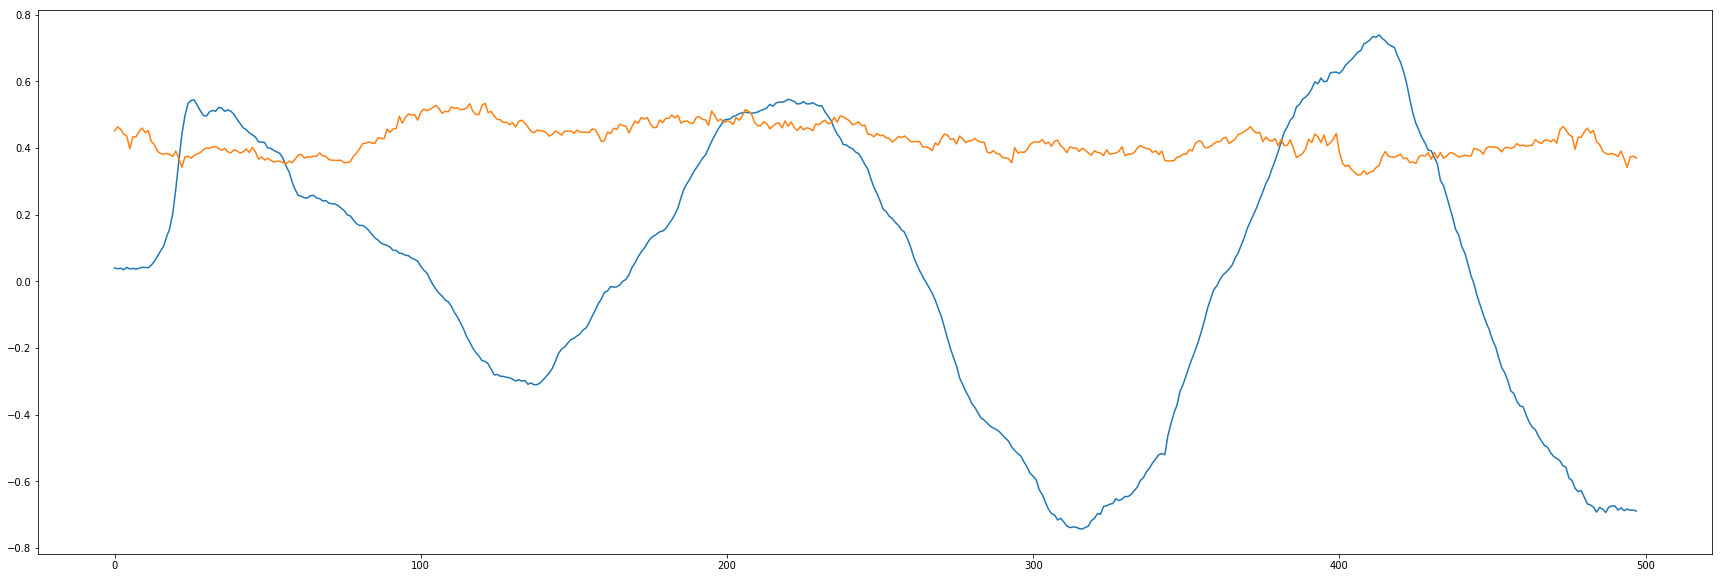

In [18]:
plt.figure(figsize=(30,10))
plt.plot(output1)

In [ ]:
predictions = full_model.predict_generator(test_gen, steps= len(test_labels[timesteps:, :1]), verbose=1)
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)